In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
plt.style.use(['science'])
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching

In [140]:
EXPERIMENT_NAME = 'r4'
KPIs = pd.read_csv('ExMAS/extras/{}_KPIs.csv'.format(EXPERIMENT_NAME), index_col = 0)
rides = pd.read_csv('ExMAS/extras/{}_rides.csv'.format(EXPERIMENT_NAME), index_col = 0)
rm = pd.read_csv('ExMAS/extras/{}_rm.csv'.format(EXPERIMENT_NAME), index_col = [0,1])

In [150]:
rm

ride  traveller  shared  degree  treq  ride_time  dist  ttrav  \
0   0      0          0   False       1     0        258  2064    258   
1   1      1          1   False       1     7        374  2997    374   
2   2      2          2   False       1    10        127  1020    127   
3   3      3          3   False       1    17        476  3811    476   
4   4      4          4   False       1    17        642  5136    642   
...      ...        ...     ...     ...   ...        ...   ...    ...   
276 30   276         30    True       2   132        411  2741    342   
    54   276         54    True       2   268        411  1873    234   
277 4    277          4    True       3    17       1009  5136    642   
    12   277         12    True       3    35       1009  5625    703   
    47   277         47    True       3   225       1009  1963    245   

        ttrav_sh  delay  distance  cost_veh  cost_user  total_group_cost  \
0   0        258    0.0      2064   2.17390   0.903000           3.07690   
1   1        374    0.0      2992   2.70170   1.309000           4.01070   
2   2        127    0.0      1016   1.57785   0.444500           2.02235   
3   3        476    0.0      3808   3.16580   1.666000           4.83180   
4   4        642    0.0      5136   3.92110   2.247000           6.16810   
...          ...    ...       ...       ...        ...               ...   
276 30       396   13.5      3288   2.87005   1.456875           5.28680   
    54       272    1.5      3288   2.87005   0.959875           5.28680   
277 4        777  -68.0      8072   5.59095   3.076500          14.86420   
    12       840   83.0      8072   5.59095   3.375750          14.86420   
    47       587  146.0      8072   5.59095   2.821000          14.86420   

        cost_single  total_singles  residual_user   UNIFORM  desired_UNIFORM  \
0   0       3.07690        3.07690         0.0000  3.076900         3.076900   
1   1       4.01070        4.01070         0.0000  4.010700         3.396075   
2   2       2.02235        2.02235         0.0000  2.022350         2.022350   
3   3       4.83180        4.83180         0.0000  4.831800         4.279125   
4   4       6.16810        6.16810         0.0000  6.168100         3.812925   
...             ...            ...            ...       ...              ...   
276 30      3.75310        6.63680        -1.3500  2.643400         2.486600   
    54      2.88370        6.63680        -1.3500  2.643400         2.373200   
277 4       6.16810       15.79950        -0.9353  4.954733         3.812925   
    12      6.65915       15.79950        -0.9353  4.954733         4.615300   
    47      2.97225       15.79950        -0.9353  4.954733         2.473825   

        EXTERNALITY  desired_EXTERNALITY  RESIDUAL  desired_RESIDUAL  \
0   0       3.07690              3.07690  3.076900          3.076900   
1   1       4.01070              3.69915  4.010700          3.832409   
2   2       2.02235              2.02235  2.022350          2.022350   
3   3       4.83180              3.66205  4.831800          4.264387   
4   4       6.16810              4.64870  6.168100          5.191322   
...             ...                  ...       ...               ...   
276 30      2.40310              2.08950  2.939288          2.756129   
    54      1.53370              1.22010  2.347512          2.217071   
277 4       4.64870              4.64870  5.857804          5.191322   
    12      6.47850              4.84330  6.318672          5.627350   
    47      3.18010              2.09615  2.687724          2.504264   

        SUBGROUP  desired_SUBGROUP  \
0   0   3.076900          3.076900   
1   1   4.010700          4.010700   
2   2   2.022350          2.022350   
3   3   4.279125          4.279125   
4   4   5.842050          5.842050   
...          ...               ...   
276 30  2.486600          2.486600   
    54  2.486600          2.486600   
277 4   5.842050          5.842050   
    12  5.84

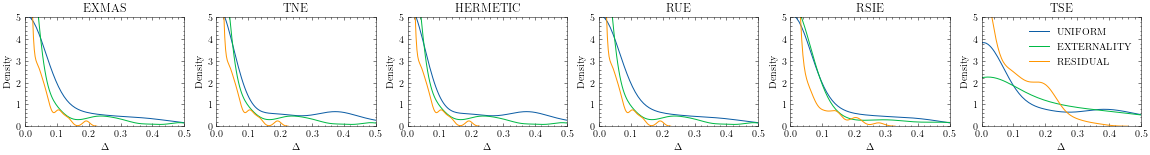

In [149]:
PRICINGS = ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']
fig, axes = plt.subplots(1,6, figsize = (20,2))
j=-1
for i,PRICING in enumerate(PRICINGS):
    
    for j, ALGO in enumerate(['EXMAS', 'TNE', 'HERMETIC', 'RUE', 'RSIE', 'TSE']):
        
        col = "Experiment-{}_Pricing-{}_Objective-['total_group_cost']_Pruning-['{}']_minmax-min".format(EXPERIMENT_NAME, PRICING, ALGO)
        
        rm['bestpossible_{}_{}'.format(PRICING,ALGO)] = rm.apply(lambda r: rm[(rm.traveller == r.traveller) & (rm[col] == 1)][PRICING].min(), axis=1)
        to_plot = rm[rm[col] == 1]
        
        to_plot['$\Delta$']=(to_plot[PRICING]-to_plot['desired_{}'.format(PRICING)])/to_plot['desired_{}'.format(PRICING)]
        sns.distplot(to_plot['$\Delta$'],ax = axes[j], kde = True, hist = False, label = PRICING) 
        axes[j].set_xlim((0,0.5))
        axes[j].set_title(ALGO)
        axes[j].set_ylim((0,5))
axes[-1].legend()
plt.savefig('hist.png', dpi = 600)

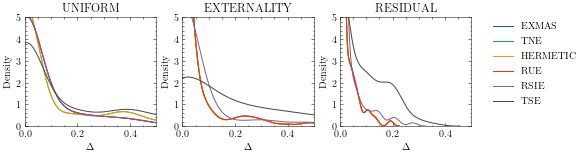

In [142]:
PRICINGS = ['UNIFORM','EXTERNALITY','RESIDUAL']
fig, axes = plt.subplots(1,3, figsize = (8,2))
j=-1
for i,PRICING in enumerate(PRICINGS):
    
    for j, ALGO in enumerate(['EXMAS', 'TNE', 'HERMETIC', 'RUE', 'RSIE', 'TSE']):
        
        col = "Experiment-{}_Pricing-{}_Objective-['total_group_cost']_Pruning-['{}']_minmax-min".format(EXPERIMENT_NAME, PRICING, ALGO)
        to_plot = rm[rm[col] == 1]
        to_plot['$\Delta$']=(to_plot[PRICING]-to_plot['desired_{}'.format(PRICING)])/to_plot['desired_{}'.format(PRICING)]
        sns.distplot(to_plot['$\Delta$'],ax = axes[i], kde = True, hist = False, label = ALGO) 
        axes[i].set_xlim((0,0.5))
        axes[i].set_title(PRICING)
        axes[i].set_ylim((0,5))
axes[-1].legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('hist2.png', dpi = 600)

In [144]:
KPIs['pricing'] = KPIs.apply(lambda x: x.name.split("_")[1].split("-")[1],axis =1)
KPIs['$T_i$'] = KPIs['PassHourTrav']/3600
KPIs['$T_G$'] = KPIs['VehHourTrav']/3600
#KPIs['prun'] = KPIs.apply(lambda x: x.algo[2:-2] if "[" in x.algo else x.algo,axis =1)
#KPIs['prun'] = KPIs.apply(lambda x: 'EXMAS' if len(x.prun) == 0 else x.prun,axis =1)
KPIs['$C$'] = KPIs['cost_user']

<AxesSubplot:xlabel='algo', ylabel='$T_i$'>

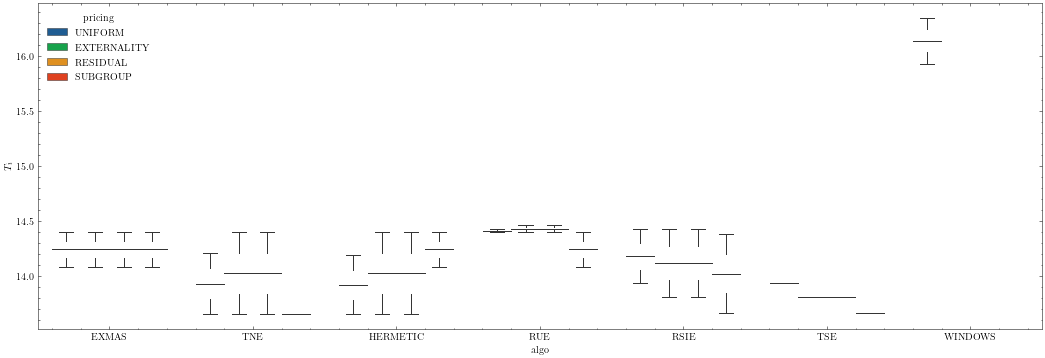

In [112]:
fig, axes = plt.subplots(figsize = (18,6))
flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none')
sns.boxplot(y = '$T_i$', x = 'algo', hue = 'pricing', data = KPIs,linewidth = 1,  showfliers=True, ax = axes, boxprops=dict(alpha=.0), whis = [0,100])

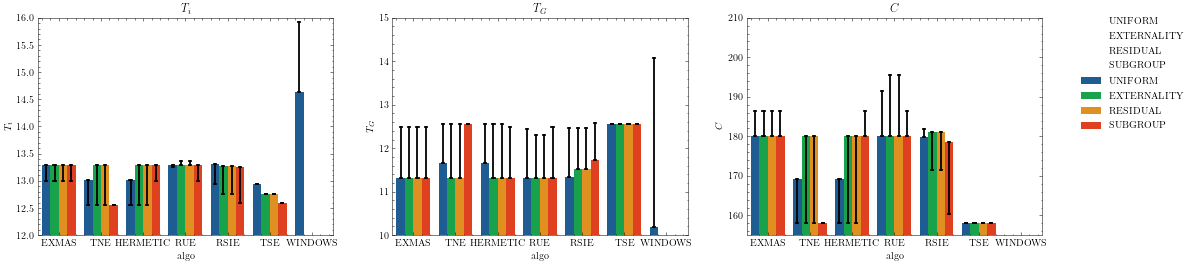

In [147]:
fig, axes = plt.subplots(1,3, figsize = (18,4))
for i, KPI in enumerate(['$T_i$','$T_G$', '$C$']):
    sns.barplot(y = KPI, x = 'algo', hue = 'pricing', data = KPIs, alpha = 0, ci = 100, capsize = 0.05, ax = axes[i], errcolor = 'black')
    sns.barplot(y = KPI, x = 'algo', hue = 'pricing', data = KPIs[KPIs.minmax == 'min'], alpha = 1, ci = 100, capsize = 0.05, ax = axes[i])
    if i==2:
        _ = axes[i].legend(bbox_to_anchor=(1.1, 1.05))
    else:
        axes[i].get_legend().remove()
    axes[i].set_title(KPI)
axes[0].set_ylim((12,16))
axes[1].set_ylim((10,15))
axes[2].set_ylim((155,210))



#connector, caplines, (vertical_lines,) = container.errorbar.lines
#vertical_lines.set_color(colors)
plt.savefig('bars.png',dpi=600)

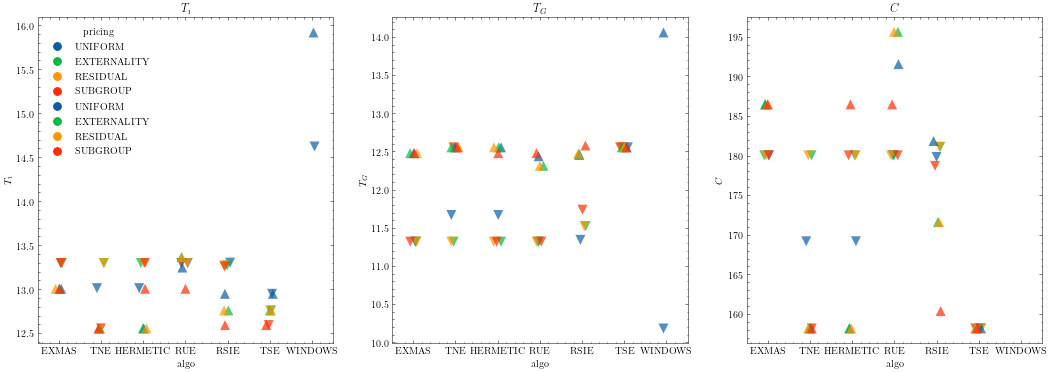

In [148]:
fig, axes = plt.subplots(1,3, figsize = (18,6))
for i, KPI in enumerate(['$T_i$','$T_G$', '$C$']):
    sns.stripplot(y = KPI, x = 'algo', hue = 'pricing', data = KPIs[KPIs.minmax == 'min'], ax = axes[i], marker = 'v', s= 10, alpha = 0.7)
    if i==0:
        _ = axes[i].legend(bbox_to_anchor=(1.1, 1.05))
    else:
        axes[i].get_legend().remove()
    sns.stripplot(y = KPI, x = 'algo', hue = 'pricing', data = KPIs[KPIs.minmax == 'max'], ax = axes[i], marker = '^', s=10,  alpha = 0.7)
    if i != 0: 
        axes[i].get_legend().remove()
    axes[i].set_title(KPI)
plt.savefig('dots.png',dpi=600)

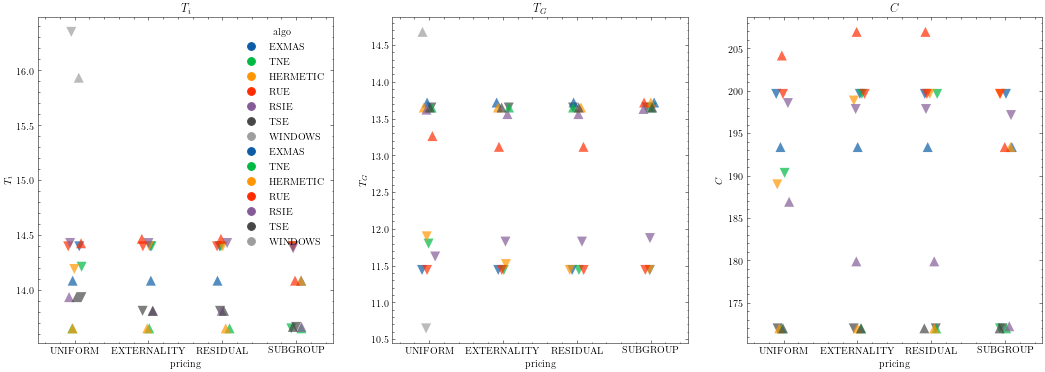

In [109]:
fig, axes = plt.subplots(1,3, figsize = (18,6))
for i, KPI in enumerate(['$T_i$','$T_G$', '$C$']):
    sns.stripplot(y = KPI, x = 'pricing', hue = 'algo', data = KPIs[KPIs.minmax == 'min'], ax = axes[i], marker = 'v', s= 10, alpha = 0.7)
    if i==0:
        _ = axes[i].legend(bbox_to_anchor=(1.1, 1.05))
    else:
        axes[i].get_legend().remove()
    sns.stripplot(y = KPI, x = 'pricing', hue = 'algo', data = KPIs[KPIs.minmax == 'max'], ax = axes[i], marker = '^', s=10,  alpha = 0.7)
    if i != 0: 
        axes[i].get_legend().remove()
    axes[i].set_title(KPI)


---
(c) Rafał Kucharski, Delft, 2020